In [1]:
QUICKTEST = False
hidden_size = 50
window_size = 12
training_start = 0.4
prediction_start = 0.8

In [2]:
# Dataset: https://www.kaggle.com/datasets/chirag19/air-passengers
!git clone https://github.com/baobuiquang/ParallelLSTM.git &> /dev/null

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import cuda

import warnings
from numba import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
np.random.seed(42)

# Functions

In [4]:
def randn(x, y):
  return np.array([[0.5 if (u+i)%2==0 else -0.5 for u in range(y)] for i in range(x)])

def k_means_clustering(lst, k):
    centroids = sorted(lst)[:k]
    clusters = [[] for _ in range(k)]
    while True:
        new_clusters = [[] for _ in range(k)]
        for num in lst:
            distances = [abs(num - centroid) for centroid in centroids]
            closest_centroid_index = distances.index(min(distances))
            new_clusters[closest_centroid_index].append(num)
        if new_clusters == clusters:
            break
        clusters = new_clusters
        centroids = [sum(cluster) / len(cluster) for cluster in clusters]
    return clusters, centroids

In [5]:
def load_dataset(directory):

    df = pd.read_csv(directory)

    df.drop('Month', axis=1, inplace=True)
    df['Change'] = df['Passengers'].shift(-1) - df['Passengers']
    df['Upper_Bound'] = [ 0.5 * x + 15 for x in range(len(df))]
    df['Lower_Bound'] = [-0.6 * x -  7 for x in range(len(df))]
    df.dropna(inplace=True)

    def change_normalized(row):
        if row['Change'] >= 0:
            return row['Change'] / row['Upper_Bound']
        else:
            return - row['Change'] / row['Lower_Bound']
    df['Change_Normalized'] = df.apply(change_normalized, axis=1)

    k = 3
    lst = df['Change_Normalized'].tolist()
    clusters, centroids = k_means_clustering(lst, k)
    devide_lines = []
    for i in range(len(centroids) - 1):
        devide_lines.append((centroids[i] + centroids[i+1]) / 2)

    def change_encoded(row):
        for i, line in enumerate(sorted(devide_lines)):
            if row['Change_Normalized'] < line:
                return i
        return len(devide_lines)
    df['Change_Encoded'] = df.apply(change_encoded, axis=1)

    # df['Change_Encoded'] -> sequences
    raw_data = [str(e) for e in df['Change_Encoded'].to_list()]
    sequences = []
    for i in range(len(raw_data) - window_size):
        sequences.append(raw_data[i : i + window_size])
    print(sequences)

    return sequences, raw_data, df, centroids, devide_lines

In [6]:
def generate_dataset(num_sequences = 50, max_num_each_token = 5):
    samples = []
    for _ in range(num_sequences): 
        num_tokens = np.random.randint(1, max_num_each_token)
        sample = ['A'] * num_tokens + ['B'] * num_tokens + ['C'] * num_tokens + ['EOS']
        samples.append(sample)
    return samples

# Function: List of sequences -> word_to_idx, idx_to_word, num_sentences, vocab_size
def sequences_to_dicts(sequences):
    flatten = lambda l: [item for sublist in l for item in sublist] # Flatten a nested list
    all_words = flatten(sequences)
    # Count number of word occurences
    word_count = {}
    for word in flatten(sequences):
        word_count[word] = 0
    for word in flatten(sequences):
        word_count[word] = word_count[word] + 1
    # Sort by frequency
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])
    # Create a list of all unique words
    unique_words = [item[0] for item in word_count]
    # # Add UNK token to list of words
    # unique_words.append('UNK')
    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)
    # Create dictionaries so that we can go from word to index and back
    word_to_idx = {}
    idx_to_word = {}
    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word
    return word_to_idx, idx_to_word, num_sentences, vocab_size

# Function: Create and split dataset into Train/Val/Test set
def create_datasets(sequences, p_train=0.8, p_val=0.1, p_test=0.1):
    # Train/Val/Test ratio
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)
    # Split sequences into Train/Val/Test
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]
    def get_inputs_targets_from_sequences(sequences):
        inputs, targets = [], []
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
        return inputs, targets
    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)
    # Create datasets
    training_set = [(inputs_train[i], targets_train[i]) for i in range(len(inputs_train))]
    validation_set = [(inputs_val[i], targets_val[i]) for i in range(len(inputs_val))]
    test_set = [(inputs_test[i], targets_test[i]) for i in range(len(inputs_test))]    
    return training_set, validation_set, test_set

In [7]:
def one_hot_encode(idx, vocab_size):
    one_hot = np.zeros(vocab_size)
    one_hot[idx] = 1.0
    return one_hot

def one_hot_encode_sequence(sequence, vocab_size):
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    return encoding

In [8]:
def sigmoid(x, derivative=False):
    if derivative:
        return (1 / (1 + np.exp(- x - 1e-12))) * (1 - (1 / (1 + np.exp(- x - 1e-12))))
    else:
        return 1 / (1 + np.exp(- x - 1e-12))

def tanh(x, derivative=False):
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    if derivative:
        return 1-f**2
    else:
        return f

def softmax(x, derivative=False):
    if derivative:
        pass
    else:
        return np.exp(x + 1e-12) / np.sum(np.exp(x + 1e-12))

def update_parameters(params, grads, lr):
    for param, grad in zip(params, grads):
        param -= lr * grad * 10.0
    return params

In [9]:
def init_orthogonal(param):
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")
    rows, cols = param.shape
    new_param = randn(rows, cols)
    if rows < cols:
        new_param = new_param.T
    q, r = np.linalg.qr(new_param)
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph
    if rows < cols:
        q = q.T
    new_param = q
    return new_param

def init_lstm(hidden_size, vocab_size):
    U = np.zeros((hidden_size, vocab_size))
    V = np.zeros((hidden_size, hidden_size))
    W = np.zeros((vocab_size, hidden_size))
    b_hidden = np.zeros((hidden_size, 1))
    b_out = np.zeros((vocab_size, 1))
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)
    return U, V, W, b_hidden, b_out

def forward_pass(inputs, h, U, V, W, B, b_out, outputs, h_s):
    for idf in range(len(inputs)):
        h = tanh(np.dot(U, inputs[idf]) + np.dot(V, h) + B)
        h_s[idf] = h
        outputs[idf] = softmax(np.dot(W, h) + b_out)
    return outputs, h_s

def backward_pass(inputs, outputs, h_s, targets, V, W, d_U, d_V, d_W, d_B, d_h_next):
    loss = 0
    for idb_r in range(hidden_size):
        d_h_next[idb_r][0] = 0
    for idb in reversed(range(len(inputs))):
        loss = loss - np.mean(np.log(outputs[idb]+1e-12) * targets[idb])
        outputs[idb][np.argmax(targets[idb])] = outputs[idb][np.argmax(targets[idb])] - 1
        d_f = tanh(h_s[idb], derivative=True) * (np.dot(W.T, outputs[idb]) + d_h_next)
        d_h_next = np.dot(V.T, d_f)
        d_U = d_U + np.dot(d_f, inputs[idb].T)
        if idb != 0:
            d_V = d_V + np.dot(d_f, h_s[idb-1].T)
        elif idb == 0:
            d_V = d_V + np.dot(d_f, h_s[len(inputs)-1].T)
        d_W = d_W + np.dot(outputs[idb], h_s[idb].T)
        d_B = d_B + d_f
    clip_coef = 0.25 / (np.sqrt(np.sum(np.power(d_U, 2)) + np.sum(np.power(d_V, 2)) + np.sum(np.power(d_W, 2)) + np.sum(np.power(d_B, 2))) + 1e-6)
    if clip_coef < 1:
        d_U = d_U * clip_coef
        d_V = d_V * clip_coef
        d_W = d_W * clip_coef
        d_B = d_B * clip_coef
    return loss, d_U, d_V, d_W, d_B

# params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size)
# test_input_sequence, test_target_sequence = training_set[0]
# test_input = one_hot_encode_sequence(test_input_sequence, vocab_size)
# test_target = one_hot_encode_sequence(test_target_sequence, vocab_size)
# hidden_state = np.zeros((hidden_size, 1))
# U, V, W, B, b_out = params
# d_U_TEMP = np.zeros((hidden_size, vocab_size))
# d_V_TEMP = np.zeros((hidden_size, hidden_size))
# d_W_TEMP = np.zeros((vocab_size, hidden_size))
# d_B_TEMP = np.zeros((hidden_size, 1))
# d_h_next_TEMP = np.zeros((hidden_size, 1))
# outputs = np.zeros((len(test_input), vocab_size, 1))
# h_s = np.zeros((len(test_input), hidden_size, 1))
# outputs, hidden_states = forward_pass(test_input, hidden_state, U, V, W, B, b_out, outputs, h_s)
# loss, _, _, _, _ = backward_pass(test_input, outputs, hidden_states, test_target, V, W, d_U_TEMP, d_V_TEMP, d_W_TEMP, d_B_TEMP, d_h_next_TEMP)
# print(outputs[0][0][0])
# print(loss)
# # 0.4737177338703963
# # 0.8153365026285508

# Dataset

In [10]:
# Initialize dataset
if QUICKTEST:
    sequences = generate_dataset(num_sequences = 500, max_num_each_token = 4)
else:
    sequences, raw_data, df, centroids, devide_lines = load_dataset(directory = '/content/ParallelLSTM/dataset/AirPassengers.csv')
    sequences = sequences[int(training_start * len(raw_data)):]

word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)
training_set, validation_set, test_set = create_datasets(sequences, p_train=0.8, p_val=0.1, p_test=0.1)

# One-hot Encoding set
training_set_one_hot = []
validation_set_one_hot = []
for idx, (inputs, targets) in enumerate(training_set):
    inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
    targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
    training_set_one_hot.append((inputs_one_hot, targets_one_hot))
for idx, (inputs, targets) in enumerate(validation_set):
    inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
    targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
    validation_set_one_hot.append((inputs_one_hot, targets_one_hot))
training_set_one_hot = tuple(training_set_one_hot)
validation_set_one_hot = tuple(validation_set_one_hot)

# Print
print(f"Example sequence: {sequences[20]}\n")
print(f"\n\nNum of sequences (Dataset size):\t{num_sequences} sequences")
print(f"Num of tokens (Vocab size):\t\t{vocab_size} tokens")
print("\nword_to_idx:")
for item in word_to_idx:
  print(f"'{item}' -> {word_to_idx[item]}")
print("\nidx_to_word:")
for item in idx_to_word:
  print(f"{item} -> '{idx_to_word[item]}'")
print(f"\nDataset splitting:")
print(f'Train:\t\t{len(training_set)} samples')
print(f'Validation:\t{len(validation_set)} samples')
print(f'Test:\t\t{len(test_set)} samples')

[['1', '2', '0', '0', '2', '2', '1', '0', '0', '0', '2', '1'], ['2', '0', '0', '2', '2', '1', '0', '0', '0', '2', '1', '2'], ['0', '0', '2', '2', '1', '0', '0', '0', '2', '1', '2', '2'], ['0', '2', '2', '1', '0', '0', '0', '2', '1', '2', '2', '0'], ['2', '2', '1', '0', '0', '0', '2', '1', '2', '2', '0', '0'], ['2', '1', '0', '0', '0', '2', '1', '2', '2', '0', '0', '2'], ['1', '0', '0', '0', '2', '1', '2', '2', '0', '0', '2', '2'], ['0', '0', '0', '2', '1', '2', '2', '0', '0', '2', '2', '1'], ['0', '0', '2', '1', '2', '2', '0', '0', '2', '2', '1', '0'], ['0', '2', '1', '2', '2', '0', '0', '2', '2', '1', '0', '0'], ['2', '1', '2', '2', '0', '0', '2', '2', '1', '0', '0', '0'], ['1', '2', '2', '0', '0', '2', '2', '1', '0', '0', '0', '2'], ['2', '2', '0', '0', '2', '2', '1', '0', '0', '0', '2', '1'], ['2', '0', '0', '2', '2', '1', '0', '0', '0', '2', '1', '1'], ['0', '0', '2', '2', '1', '0', '0', '0', '2', '1', '1', '2'], ['0', '2', '2', '1', '0', '0', '0', '2', '1', '1', '2', '0'], ['2', '

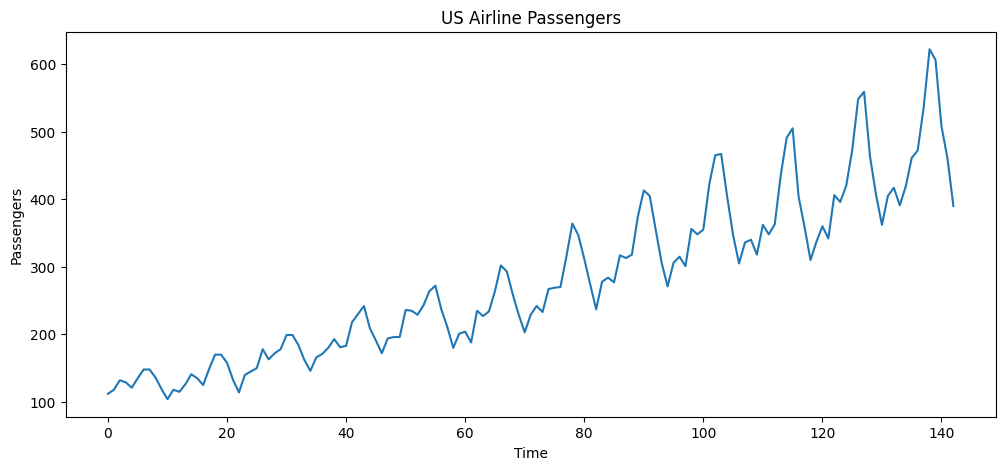

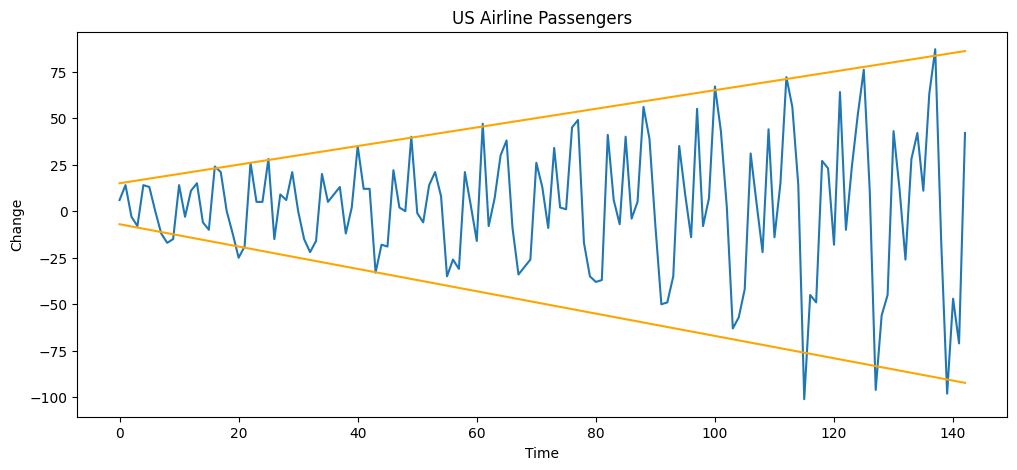

Centroids:
[-0.754, 0.06, 0.763]
Devide Lines:
[-0.347, 0.412]


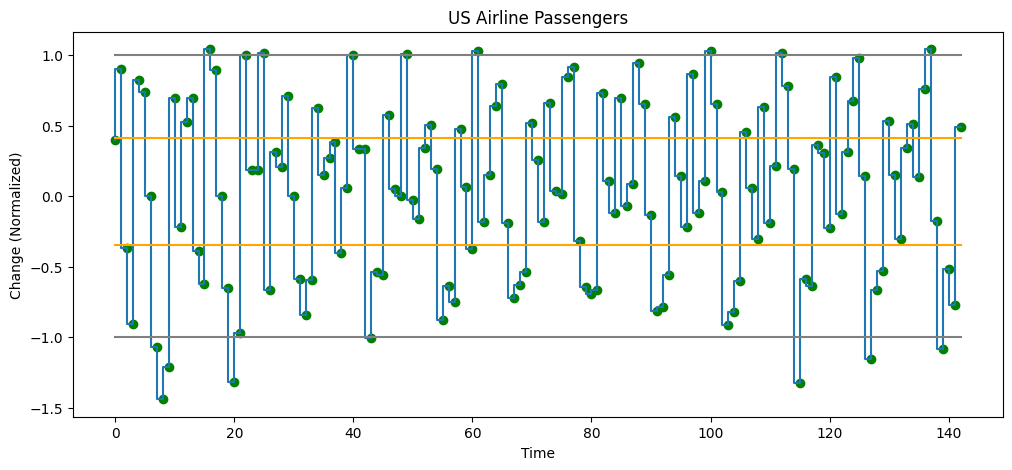

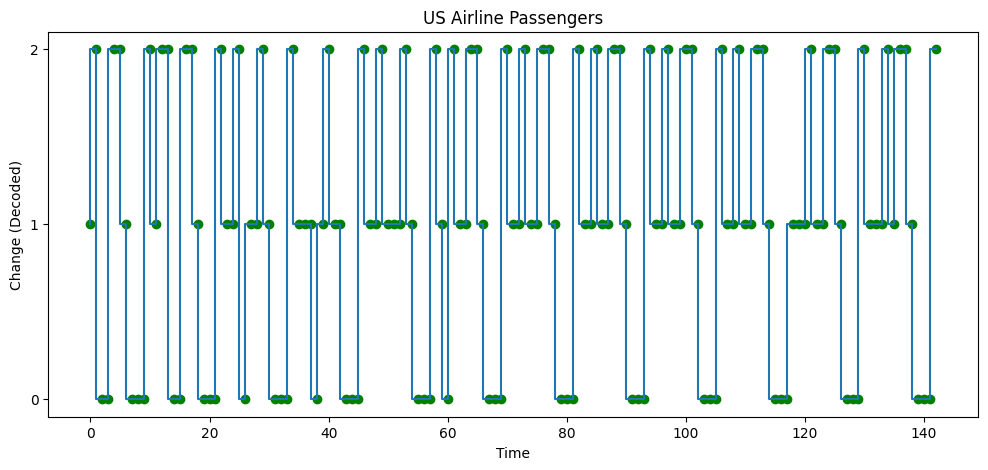

In [11]:
if not QUICKTEST:

    plt.figure(figsize=(12, 5))
    plt.plot(df['Passengers'])
    plt.xlabel('Time')
    plt.ylabel('Passengers')
    plt.title('US Airline Passengers')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(df['Change'])
    plt.plot(df['Upper_Bound'], color = 'orange')
    plt.plot(df['Lower_Bound'], color = 'orange')
    plt.xlabel('Time')
    plt.ylabel('Change')
    plt.title('US Airline Passengers')
    plt.show()

    print('Centroids:')
    print([round(c,3) for c in centroids])
    print('Devide Lines:')
    print([round(l,3) for l in devide_lines])
    plt.figure(figsize=(12, 5))
    plt.step(range(len(df)), df['Change_Normalized'])
    plt.scatter(range(len(df)), df['Change_Normalized'], color='green')
    plt.plot([ 1.0 for _ in range(len(df))], color = 'gray')
    for line in devide_lines:
        plt.plot([line for _ in range(len(df))], color = 'orange')
    plt.plot([-1.0 for _ in range(len(df))], color = 'gray')
    plt.xlabel('Time')
    plt.ylabel('Change (Normalized)')
    plt.title('US Airline Passengers')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.step(range(len(df)), df['Change_Encoded'])
    plt.scatter(range(len(df)), df['Change_Encoded'], color='green')
    plt.yticks(range(len(devide_lines)+1))
    plt.xlabel('Time')
    plt.ylabel('Change (Decoded)')
    plt.title('US Airline Passengers')
    plt.show()

# Train LSTM

In [12]:
### 🟢 Parallel
# @cuda.jit
# LOOP THROUGH SAMPLES IN A MINI-BATCH
def loop_samples_in_minibatch(minibatch_set, U, V, W, B, b_out, d_U, d_V, d_W, d_B, d_f, h_s, h_s_s, train_losses, valid_losses, outputs, round_decimal):

    # For each sentence in validation set
    for idx in range(len(minibatch_set)):

        inputs = minibatch_set[idx][0]
        targets = minibatch_set[idx][1]

        # ------------------------------ Forward Pass ------------------------------
        for idf in range(len(inputs)):
            
            h_s[idx] = tanh(np.dot(U, inputs[idf]) + np.dot(V, h_s[idx]) + B) # (hidden_size, 1) # ✅
            # for r in range(hidden_size):
            #     d_f[idx][r][0] = 0.0
            #     for u in range(hidden_size):
            #         d_f[idx][r][0] = round(d_f[idx][r][0] + (V[r][u] * h_s[idx][u][0]), round_decimal)
            # for r in range(hidden_size):
            #     h_s_dot_1 = 0.0
            #     for u in range(vocab_size):
            #         h_s_dot_1 = round(h_s_dot_1 + (U[r][u] * inputs[idf][u][0]), round_decimal)
            #     h_s[idx][r][0] = round(math.tanh(h_s_dot_1 + d_f[idx][r][0] + B[r][0]), round_decimal)

            h_s_s[idx][idf] = h_s[idx] # (hidden_size, 1) # ✅
            # for r in range(hidden_size):
            #     h_s_s[idx][idf][r][0] = h_s[idx][r][0]

            outputs[idx][idf] = softmax(np.dot(W, h_s[idx]) + b_out) # (vocab_size, 1) # ✅
            # sum_softmax = 0.0
            # for r in range(vocab_size):
            #     softmax = 0.0
            #     for u in range(W.shape[1]):
            #         softmax = round(softmax + (W[r][u] * h_s[idx][u][0] + b_out[r][0]), round_decimal)
            #     sum_softmax = round(sum_softmax + math.exp(softmax + 1e-12), round_decimal)
            #     outputs[idx][idf][r][0] = round(math.exp(softmax + 1e-12), round_decimal)
            # for r in range(vocab_size):
            #     outputs[idx][idf][r][0] = round(outputs[idx][idf][r][0] / sum_softmax, round_decimal)

        # ------------------------------ Backward Pass ------------------------------
        loss = 0
        for idb_r in range(hidden_size):
            h_s[idx][idb_r][0] = 0.0
        for idb_reversed in range(len(inputs)):
            idb = len(inputs) - idb_reversed - 1

            loss = loss - np.mean(np.log(outputs[idx][idb]+1e-12) * targets[idb]) # ✅
            # loss_mean = 0.0
            # for r in range(vocab_size):
            #     loss_mean = round(loss_mean + (math.log(outputs[idx][idb][r][0] + 1e-12) * targets[idb][r][0]), round_decimal)
            # loss_mean = round(loss_mean / vocab_size, round_decimal)
            # loss = round(loss - loss_mean, round_decimal)

            outputs[idx][idb][np.argmax(targets[idb])] = outputs[idx][idb][np.argmax(targets[idb])] - 1 # ✅
            # argmax_targets = 0
            # for r in range(1, vocab_size):
            #     if targets[idb][r][0] > targets[idb][argmax_targets][0]:
            #         argmax_targets = r
            # outputs[idx][idb][argmax_targets][0] = outputs[idx][idb][argmax_targets][0] - 1

            d_f[idx] = tanh(h_s_s[idx][idb], derivative=True) * (np.dot(W.T, outputs[idx][idb]) + h_s[idx]) # (hidden_size, 1) # df can be considered to be replaced # ✅
            # for r in range(hidden_size):
            #     d_f_dot = h_s[idx][r][0]
            #     for u in range(vocab_size):
            #         d_f_dot = round(d_f_dot + (W[u][r] * outputs[idx][idb][u][0]), round_decimal)
            #     d_f[idx][r][0] = round((1-math.pow(((math.exp(h_s_s[idx][idb][r][0] + 1e-12)-math.exp(-(h_s_s[idx][idb][r][0] + 1e-12)))/(math.exp(h_s_s[idx][idb][r][0] + 1e-12)+math.exp(-(h_s_s[idx][idb][r][0] + 1e-12)))), 2)) * d_f_dot, round_decimal)
                
            h_s[idx] = np.dot(V.T, d_f[idx]) # (hidden_size, 1) # ✅
            # for r in range(hidden_size):
            #     h_s[idx][r][0] = 0.0
            #     for u in range(V.shape[0]):
            #         h_s[idx][r][0] = round(h_s[idx][r][0] + (V[u][r] * d_f[idx][u][0]), round_decimal)

            d_U[idx] = d_U[idx] + np.dot(d_f[idx], inputs[idb].T) # (hidden_size, vocab_size) # ✅
            # for r in range(hidden_size):
            #     for c in range(vocab_size):
            #         d_U_dot = 0.0
            #         for u in range(d_f[idx].shape[1]):
            #             d_U_dot = round(d_U_dot + (d_f[idx][r][u] * inputs[idb][c][u]), round_decimal)
            #         d_U[idx][r][c] = round(d_U[idx][r][c] + d_U_dot, round_decimal)

            h_s_s[idx][-1] = h_s_s[idx][len(inputs)-1] # (hidden_size, 1) # ✅
            # for r in range(hidden_size):
            #     h_s_s[idx][-1][r][0] = h_s_s[idx][len(inputs)-1][r][0]

            d_V[idx] = d_V[idx] + np.dot(d_f[idx], h_s_s[idx][idb-1].T) # (hidden_size, hidden_size) # ✅
            # for r in range(hidden_size):
            #     for c in range(hidden_size):
            #         d_V_dot = 0.0
            #         for u in range(d_f[idx].shape[1]):
            #             d_V_dot = round(d_V_dot + (d_f[idx][r][u] * h_s_s[idx][idb-1][c][u]), round_decimal)
            #         d_V[idx][r][c] = round(d_V[idx][r][c] + d_V_dot, round_decimal)

            d_W[idx] = d_W[idx] + np.dot(outputs[idx][idb], h_s_s[idx][idb].T) # (vocab_size, hidden_size) # ✅
            # for r in range(vocab_size):
            #     for c in range(hidden_size):
            #         d_W_dot = 0.0
            #         for u in range(outputs[idx][idb].shape[1]):
            #             d_W_dot = round(d_W_dot + (outputs[idx][idb][r][u] * h_s_s[idx][idb][c][u]), round_decimal)
            #         d_W[idx][r][c] = round(d_W[idx][r][c] + d_W_dot, round_decimal)

            d_B[idx] = d_B[idx] + d_f[idx] # (hidden_size, 1) # ✅
            # for r in range(hidden_size):
            #     d_B[idx][r][0] = round(d_B[idx][r][0] + d_f[idx][r][0], round_decimal)

        # ------------------------------ Gradient Clip ------------------------------
        clip_coef = 0.25 / (np.sqrt(np.sum(np.power(d_U[idx], 2)) + np.sum(np.power(d_V[idx], 2)) + np.sum(np.power(d_W[idx], 2)) + np.sum(np.power(d_B[idx], 2))) + 1e-6) # ✅
        # clip_coef = 0.0
        # for r in range(hidden_size):
        #     for c in range(vocab_size):
        #         clip_coef = round(clip_coef + d_U[idx][r][c] * d_U[idx][r][c], round_decimal)
        #     for c in range(hidden_size):
        #         clip_coef = round(clip_coef + d_V[idx][r][c] * d_V[idx][r][c], round_decimal)
        #     clip_coef = round(clip_coef + d_B[idx][r][0] * d_B[idx][r][0], round_decimal)
        # for r in range(vocab_size):
        #     for c in range(hidden_size):
        #         clip_coef = round(clip_coef + d_W[idx][r][c] * d_W[idx][r][c], round_decimal)
        # clip_coef = round(0.25 / (math.sqrt(clip_coef) + 1e-6), round_decimal)

        if clip_coef < 1.0: # ✅
            d_U[idx] = d_U[idx] * clip_coef
            d_V[idx] = d_V[idx] * clip_coef
            d_W[idx] = d_W[idx] * clip_coef
            d_B[idx] = d_B[idx] * clip_coef
        # if clip_coef < 1.0:
        #     for r in range(hidden_size):
        #         for c in range(vocab_size):
        #             d_U[idx][r][c] = round(d_U[idx][r][c] * clip_coef, round_decimal)
        #         for c in range(hidden_size):
        #             d_V[idx][r][c] = round(d_V[idx][r][c] * clip_coef, round_decimal)
        #         d_B[idx][r][0] = round(d_B[idx][r][0] * clip_coef, round_decimal)
        #     for r in range(vocab_size):
        #         for c in range(hidden_size):
        #             d_W[idx][r][c] = round(d_W[idx][r][c] * clip_coef, round_decimal)

        # ------------------------------ Save information ------------------------------
        valid_losses[idx] = round(loss, round_decimal)
        train_losses[idx] = round(loss, round_decimal)

In [13]:
# LOOP THROUGH MINI-BATCHES
def loop_minibatches(minibatch_size, train_valid_set, params, all_valid_losses, all_train_losses, all_grads_d_U, all_grads_d_V, all_grads_d_W, all_grads_d_B, epoch_idx, round_decimal, optimize_method, learning_rate):

    U, V, W, B, b_out = params

    # Devide the train_or_val_set to mini-batch
    num_minibatchs = math.floor(len(train_valid_set) / minibatch_size) # This will ignore the last mini-batch that has smaller size

    # LOOP THROUGH MINI-BATCHES
    for i in range(num_minibatchs):

        batch_start = i * minibatch_size
        batch_end = batch_start + minibatch_size
        minibatch_set = train_valid_set[batch_start : batch_end]

        batch_train_losses = np.zeros(minibatch_size)
        batch_valid_losses = np.zeros(minibatch_size)
        batch_grads_d_U = np.zeros((minibatch_size, hidden_size, vocab_size))
        batch_grads_d_V = np.zeros((minibatch_size, hidden_size, hidden_size))
        batch_grads_d_W = np.zeros((minibatch_size, vocab_size, hidden_size))
        batch_grads_d_B = np.zeros((minibatch_size, hidden_size, 1))
        d_f = np.zeros((minibatch_size, hidden_size, 1))
        hidden_states_MEM = np.zeros((minibatch_size, hidden_size, 1))
        outputs_MEM = np.zeros((minibatch_size, 999, vocab_size, 1))
        h_s_MEM = np.zeros((minibatch_size, 999, hidden_size, 1))

        db1 = np.zeros(1)
        db2 = np.zeros(1)
        db3 = np.zeros(1)

        if optimize_method == 'minibatch':
            # Re-initialize all_grads
            all_grads = [0] * len(training_set)
            all_grads_d_U = [0] * len(training_set)
            all_grads_d_V = [0] * len(training_set)
            all_grads_d_W = [0] * len(training_set)
            all_grads_d_B = [0] * len(training_set)

        # LOOP THROUGH SAMPLES IN A MINI-BATCH
        loop_samples_in_minibatch(minibatch_set, U, V, W, B, b_out, batch_grads_d_U, batch_grads_d_V, batch_grads_d_W, batch_grads_d_B, d_f, hidden_states_MEM, h_s_MEM, batch_train_losses, batch_valid_losses, outputs_MEM, round_decimal)

        # Copy `minibatch_` back to `all_`
        all_grads_d_U[batch_start : batch_end] = batch_grads_d_U
        all_grads_d_V[batch_start : batch_end] = batch_grads_d_V
        all_grads_d_W[batch_start : batch_end] = batch_grads_d_W
        all_grads_d_B[batch_start : batch_end] = batch_grads_d_B
        all_train_losses[batch_start : batch_end] = batch_train_losses
        all_valid_losses[batch_start : batch_end] = batch_valid_losses

        if optimize_method == 'minibatch':
            # Calculate mean of grads + Update params
            for tmpi in range(len(all_grads)):
                all_grads[tmpi] = [all_grads_d_U[tmpi], all_grads_d_V[tmpi], all_grads_d_W[tmpi], all_grads_d_B[tmpi]]
            avg_grads = np.mean(all_grads, axis = 0)
            params = update_parameters(params, avg_grads, lr = learning_rate)

# TRAIN LSTM
def train_LSTM(num_epochs = 100, minibatch_size = 2, round_decimal = 10, learning_rate = 10e-1, epochs_per_print = 1, optimize_method = 'fullbatch', hidden_size = hidden_size, vocab_size = vocab_size):

    # Initialize a new network
    params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size)

    # Initialize hidden state as zeros
    hidden_state = np.zeros((hidden_size, 1))

    # Track loss
    training_loss, validation_loss = [], []

    # For each epoch
    for i in range(num_epochs+1):
        
        # Track loss
        epoch_training_loss = 0
        epoch_validation_loss = 0
        
        all_grads = [0] * len(training_set)
        all_grads_d_U = [0] * len(training_set)
        all_grads_d_V = [0] * len(training_set)
        all_grads_d_W = [0] * len(training_set)
        all_grads_d_B = [0] * len(training_set)

        all_train_losses = np.zeros(len(training_set))
        all_valid_losses = np.zeros(len(validation_set))
        all_valid_losses_dummy = np.zeros(len(training_set))

        # Loop through validation set
        loop_minibatches(minibatch_size, validation_set_one_hot, params, all_valid_losses,       all_train_losses, all_grads_d_U, all_grads_d_V, all_grads_d_W, all_grads_d_B, i, round_decimal, optimize_method, learning_rate)
        # Loop through training set
        loop_minibatches(minibatch_size, training_set_one_hot,   params, all_valid_losses_dummy, all_train_losses, all_grads_d_U, all_grads_d_V, all_grads_d_W, all_grads_d_B, i, round_decimal, optimize_method, learning_rate)
        
        if optimize_method == 'fullbatch':
            # Calculate mean of grads + Update params
            for tmpi in range(len(all_grads)):
                all_grads[tmpi] = [all_grads_d_U[tmpi], all_grads_d_V[tmpi], all_grads_d_W[tmpi], all_grads_d_B[tmpi]]
            avg_grads = np.mean(all_grads, axis = 0)
            params = update_parameters(params, avg_grads, lr = learning_rate)

        # Calculate sum of losses
        epoch_training_loss = np.sum(all_train_losses)
        epoch_validation_loss = np.sum(all_valid_losses)

        # Save loss for plot
        training_loss.append(epoch_training_loss/len(training_set))
        validation_loss.append(epoch_validation_loss/len(validation_set))

        # Print loss
        if i % epochs_per_print == 0:
            print(f'Epoch {i}:\tTrain Loss = {round(training_loss[-1], 2)}\tValid Loss = {round(validation_loss[-1], 2)} \t {training_loss[-1]} \t {validation_loss[-1]}')
            if round(training_loss[-1], round_decimal) == round(0.65017804645, round_decimal) and round(validation_loss[-1], round_decimal) == round(0.6884003186600001, round_decimal):
                print(f'👍👍👍👍👍👍👍👍👍👍\n' * 10)

    return params, training_loss, validation_loss

In [14]:
%%time
if QUICKTEST:
    params, training_loss, validation_loss = train_LSTM(num_epochs = 50, minibatch_size = 10, round_decimal = 10, learning_rate = 0.1, epochs_per_print = 10, optimize_method = 'minibatch')
else:
    params, training_loss, validation_loss = train_LSTM(num_epochs = 50, minibatch_size = 5, round_decimal = 10, learning_rate = 0.1, epochs_per_print = 10, optimize_method = 'minibatch')

Epoch 0:	Train Loss = 3.85	Valid Loss = 3.06 	 3.8509243476355937 	 3.062573737485714
Epoch 10:	Train Loss = 2.34	Valid Loss = 1.82 	 2.3378368838983055 	 1.8245689538142857
Epoch 20:	Train Loss = 1.83	Valid Loss = 1.49 	 1.8301991388067798 	 1.4865327443999998
Epoch 30:	Train Loss = 1.62	Valid Loss = 1.37 	 1.6189302198016948 	 1.3742997283857146
Epoch 40:	Train Loss = 1.49	Valid Loss = 1.34 	 1.4857380809322034 	 1.3376658148999998
Epoch 50:	Train Loss = 1.38	Valid Loss = 1.32 	 1.375735638501695 	 1.3226919952857141
CPU times: user 6.12 s, sys: 29.8 ms, total: 6.15 s
Wall time: 6.72 s


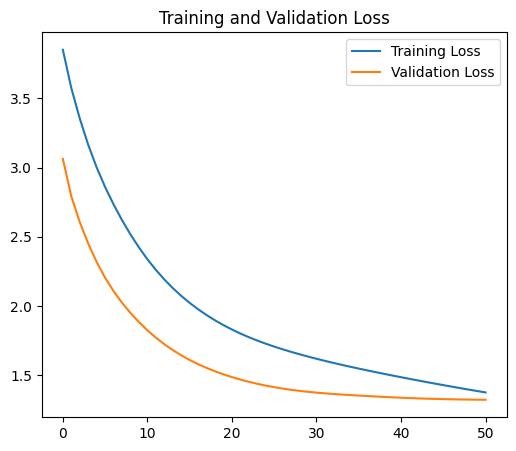

In [15]:
plt.figure(figsize=(6, 5))
plt.plot(training_loss, label = 'Training Loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Test

In [16]:
def inference_next_token(params, sentence, prob = 1):
    sentence_cut = sentence[:]
    sentence_one_hot = one_hot_encode_sequence(sentence_cut, vocab_size)
    hidden_state = np.zeros((hidden_size, 1))
    U, V, W, b_hidden, b_out = params
    outputs = np.zeros((len(sentence_one_hot), vocab_size, 1))
    h_s = np.zeros((len(sentence_one_hot), hidden_size, 1))
    outputs, hidden_states = forward_pass(sentence_one_hot, hidden_state, U, V, W, b_hidden, b_out, outputs, h_s)
    output_sentence = sentence
    word = idx_to_word[np.argsort(np.max(outputs[-1], axis=1))[-prob]]
    output_sentence.append(word)
    return output_sentence

def inference_next_sequence(params, sentence, num_tokens = 1):
    output = sentence.split(' ')
    for _ in range(num_tokens):
        output = inference_next_token(params, output)
    return output

In [17]:
if QUICKTEST:
    input_sequence = 'A A B'
else:
    #                 0 0 2 1 1 2 1 1 2 2 1 0   
    input_sequence = '0 0 2 1'

# Inference
prediction = inference_next_sequence(params = params, sentence = input_sequence, num_tokens = 8)

print(f"Prediction: {prediction}")

Prediction: ['0', '0', '2', '1', '1', '2', '1', '1', '2', '2', '1', '0']


# Make prediction

In [18]:
prediction_starting_point = int(prediction_start * len(raw_data))

input_sequence = ' '.join([e for e in raw_data[prediction_starting_point : prediction_starting_point + window_size]])

num_tokens_to_predict = len(raw_data) - prediction_starting_point
prediction = inference_next_sequence(params = params, sentence = input_sequence, num_tokens = num_tokens_to_predict)[window_size:]
print(prediction)

['1', '0', '0', '0', '2', '1', '1', '2', '1', '1', '2', '2', '1', '0', '0', '0', '2', '1', '1', '2', '1', '1', '2', '2', '1', '0', '0', '0', '2']


In [19]:
print(raw_data)

['1', '2', '0', '0', '2', '2', '1', '0', '0', '0', '2', '1', '2', '2', '0', '0', '2', '2', '1', '0', '0', '0', '2', '1', '1', '2', '0', '1', '1', '2', '1', '0', '0', '0', '2', '1', '1', '1', '0', '1', '2', '1', '1', '0', '0', '0', '2', '1', '1', '2', '1', '1', '1', '2', '1', '0', '0', '0', '2', '1', '0', '2', '1', '1', '2', '2', '1', '0', '0', '0', '2', '1', '1', '2', '1', '1', '2', '2', '1', '0', '0', '0', '2', '1', '1', '2', '1', '1', '2', '2', '1', '0', '0', '0', '2', '1', '1', '2', '1', '1', '2', '2', '1', '0', '0', '0', '2', '1', '1', '2', '1', '1', '2', '2', '1', '0', '0', '0', '1', '1', '1', '2', '1', '1', '2', '2', '1', '0', '0', '0', '2', '1', '1', '1', '2', '1', '2', '2', '1', '0', '0', '0', '2']


In [20]:
prediction_data = raw_data[:prediction_starting_point] + prediction
prediction_data = [int(e) for e in prediction_data]
print(prediction_data)

[1, 2, 0, 0, 2, 2, 1, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 2, 1, 0, 0, 0, 2, 1, 1, 2, 0, 1, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1, 0, 0, 0, 2, 1, 0, 2, 1, 1, 2, 2, 1, 0, 0, 0, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, 0, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, 0, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, 0, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, 0, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, 0, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, 0, 2]


In [21]:
len(prediction_data)

143

In [22]:
df['Prediction_Encoded'] = prediction_data
df

,Passengers,Change,Upper_Bound,Lower_Bound,Change_Normalized,Change_Encoded,Prediction_Encoded
0,112,6.0,15.0,-7.0,0.400000,1,1
1,118,14.0,15.5,-7.6,0.903226,2,2
2,132,-3.0,16.0,-8.2,-0.365854,0,0
3,129,-8.0,16.5,-8.8,-0.909091,0,0
4,121,14.0,17.0,-9.4,0.823529,2,2
...,...,...,...,...,...,...,...
138,622,-16.0,84.0,-89.8,-0.178174,1,1
139,606,-98.0,84.5,-90.4,-1.084071,0,0
140,508,-47.0,85.0,-91.0,-0.516484,0,0
141,461,-71.0,85.5,-91.6,-0.775109,0,0


In [23]:
centroids

[-0.7544718508961868, 0.06044513110478332, 0.7625867685511853]

In [24]:
devide_lines

[-0.34701335989570176, 0.41151594982798434]

In [25]:
def prediction_decode(row):
    centroid = centroids[-1]
    for i, line in enumerate(sorted(devide_lines)):
        if row['Prediction_Encoded'] == i:
            centroid = centroids[i]
    if row['Change_Normalized'] >= 0:
        return centroid * row['Upper_Bound']
    else:
        return - centroid * row['Lower_Bound']
df['Change_Prediction'] = df.apply(prediction_decode, axis=1)

df

,Passengers,Change,Upper_Bound,Lower_Bound,Change_Normalized,Change_Encoded,Prediction_Encoded,Change_Prediction
0,112,6.0,15.0,-7.0,0.400000,1,1,0.906677
1,118,14.0,15.5,-7.6,0.903226,2,2,11.820095
2,132,-3.0,16.0,-8.2,-0.365854,0,0,-6.186669
3,129,-8.0,16.5,-8.8,-0.909091,0,0,-6.639352
4,121,14.0,17.0,-9.4,0.823529,2,2,12.963975
...,...,...,...,...,...,...,...,...
138,622,-16.0,84.0,-89.8,-0.178174,1,1,5.427973
139,606,-98.0,84.5,-90.4,-1.084071,0,0,-68.204255
140,508,-47.0,85.0,-91.0,-0.516484,0,0,-68.656938
141,461,-71.0,85.5,-91.6,-0.775109,0,0,-69.109622


In [26]:
passengers_raw = df['Passengers'].to_list()
passengers_pred = df['Change_Prediction'].to_list()[prediction_starting_point:]
passengers_prediction = passengers_raw[:prediction_starting_point]
for pred in passengers_pred:
    passengers_prediction.append(passengers_prediction[-1] + pred)

df['Passengers_Prediction'] = passengers_prediction

df

,Passengers,Change,Upper_Bound,Lower_Bound,Change_Normalized,Change_Encoded,Prediction_Encoded,Change_Prediction,Passengers_Prediction
0,112,6.0,15.0,-7.0,0.400000,1,1,0.906677,112.000000
1,118,14.0,15.5,-7.6,0.903226,2,2,11.820095,118.000000
2,132,-3.0,16.0,-8.2,-0.365854,0,0,-6.186669,132.000000
3,129,-8.0,16.5,-8.8,-0.909091,0,0,-6.639352,129.000000
4,121,14.0,17.0,-9.4,0.823529,2,2,12.963975,121.000000
...,...,...,...,...,...,...,...,...,...
138,622,-16.0,84.0,-89.8,-0.178174,1,1,5.427973,607.167233
139,606,-98.0,84.5,-90.4,-1.084071,0,0,-68.204255,538.962977
140,508,-47.0,85.0,-91.0,-0.516484,0,0,-68.656938,470.306039
141,461,-71.0,85.5,-91.6,-0.775109,0,0,-69.109622,401.196417


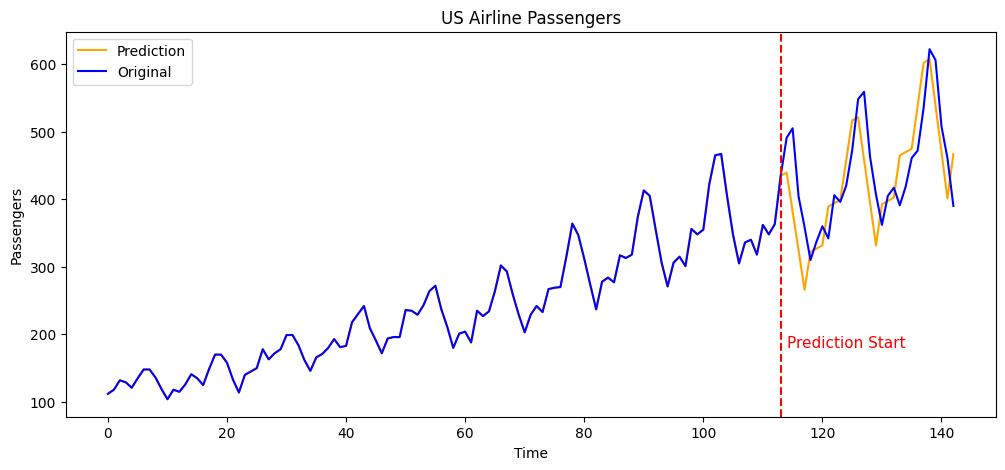

In [27]:
plt.figure(figsize=(12, 5))
plt.plot(df['Passengers_Prediction'], color='orange', label='Prediction')
plt.plot(df['Passengers'], color='blue', label='Original')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('US Airline Passengers')
plt.axvline(x = int(prediction_start * len(df)) - 1, linestyle='--', color='red')
plt.text(114, 180, 'Prediction Start', fontsize=11, color='red')
plt.legend()
plt.show()